In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

import optuna

In [3]:
os.environ['OPENBLAS_NUM_THREADS'] = "1"

In [4]:
DATA_PATH = Path("../data")

In [5]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 2.71 s, sys: 627 ms, total: 3.34 s
Wall time: 3.69 s


In [6]:
Columns.Datetime = 'last_watch_dt'

# Preprocess Interactions

In [7]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [8]:
interactions.dtypes

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object

In [9]:
interactions.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

In [10]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [11]:
interactions.dropna(inplace=True)

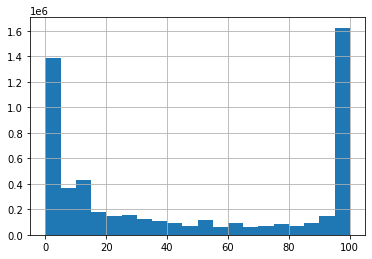

In [12]:
interactions['watched_pct'].hist(bins=20);

Делю график просмотра на 5 категорий, где:  
от 0% до 20%  = 1,  
от 21% до 40% = 2,  
... ,  
от 80% до 100% = 5

In [13]:
interactions[Columns.Weight] = np.where((interactions['watched_pct'] > 20), 2, 1)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 40, 3, inplace=True)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 60, 4, inplace=True)
interactions[Columns.Weight].mask(interactions['watched_pct'] > 80, 5, inplace=True)

<AxesSubplot:>

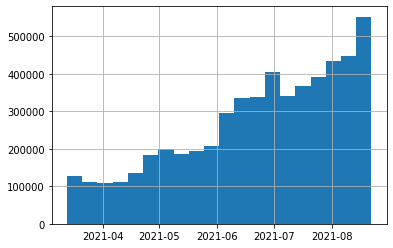

In [14]:
interactions[Columns.Datetime].hist(bins=20)

Вообще, видно, что кол-во пользователей растет

In [15]:
cold_users = interactions[Columns.User].value_counts()[interactions[Columns.User].value_counts() == 1].index

<AxesSubplot:>

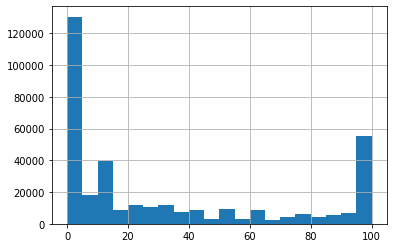

In [16]:
interactions[interactions[Columns.User].isin(cold_users)]['watched_pct'].hist(bins=20)

Для холодных пользователей, я бы рекомендовал айтемы с самый высоким просмотром в среднем по холодным пользователям

In [17]:
cold_users = interactions[interactions[Columns.User].isin(cold_users)]
hot_users = interactions[~interactions[Columns.User].isin(cold_users)]
cold_users

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
10,791466,8199,2021-07-27,713,9.0,1
26,181144,10440,2021-08-08,27408,40.0,2
37,161176,10440,2021-07-29,22,0.0,1
38,21723,1819,2021-04-11,8535,100.0,5
60,77216,8143,2021-05-08,660,11.0,1
...,...,...,...,...,...,...
5476222,1007900,9728,2021-08-12,416,6.0,1
5476225,882138,4716,2021-05-21,1594,2.0,1
5476238,805174,13125,2021-06-27,1,0.0,1
5476246,648596,12225,2021-08-13,76,0.0,1


In [20]:
hot_users

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5
...,...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0,1
5476247,546862,9673,2021-04-13,2308,49.0,3
5476248,697262,15297,2021-08-20,18307,63.0,4
5476249,384202,16197,2021-04-19,6203,100.0,5


In [21]:
cold_users['item_id'].value_counts().to_frame()

,item_id
10440,45695
15297,39309
2657,20474
9728,15140
4740,11455
...,...
1946,1
13886,1
14090,1
5730,1


In [22]:
cold_users[['item_id', 'total_dur']].groupby('item_id').mean().sort_values(by='total_dur', ascending=False).head(10).index

Int64Index([609, 4895, 3825, 5069, 14092, 12593, 7142, 2271, 13673, 11566], dtype='int64', name='item_id')

# Делим на train и test

In [23]:
max_date = hot_users[Columns.Datetime].max()

In [24]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4984443, 6)
test: (490980, 6)


In [25]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [26]:
drop_user = set(test[Columns.User]) - set(train[Columns.User])

In [27]:
test.drop(test[test[Columns.User].isin(drop_user)].index, inplace=True)

In [28]:
test

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
9,203219,13582,2021-08-22,6975,100.0,5
54,200197,9335,2021-08-16,83,2.0,1
64,73446,14488,2021-08-19,6011,100.0,5
84,10010,512,2021-08-15,14,0.0,1
94,890735,14200,2021-08-16,1179,28.0,2
...,...,...,...,...,...,...
5476169,589589,983,2021-08-21,2403,43.0,3
5476188,590892,8618,2021-08-21,1335,23.0,2
5476191,857162,12360,2021-08-16,11,0.0,1
5476201,273558,10605,2021-08-21,34030,100.0,5


# User preprocess

In [29]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


In [30]:
users.isnull().sum()/840197

user_id     0.000000
age         0.016776
income      0.017586
sex         0.016462
kids_flg    0.000000
dtype: float64

In [31]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

Заменяю Nan'ы на Unknown

In [32]:
users.fillna('Unknown', inplace=True)


In [33]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


# Item preprocess

In [34]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [35]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [36]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

In [37]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       3775
release_year       31
genres              0
countries          14
for_kids        13415
age_rating          1
studios         13047
directors         939
actors           1858
description         0
keywords          388
dtype: int64

# Genre

In [38]:
# Explode genres to flatten table
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [39]:
genre_feature

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre


# Content

In [40]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type
...,...,...,...
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type


# Actors

In [41]:
items["actors"] = items["actors"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
actors_feature = items[["item_id", "actors"]].explode("actors")
actors_feature.columns = ["id", "value"]
actors_feature["feature"] = "actors"
actors_feature

,id,value,feature
0,10711,адольфо фернандес,actors
0,10711,ана фернандес,actors
0,10711,дарио грандинетти,actors
0,10711,джеральдин чаплин,actors
0,10711,елена анайя,actors
...,...,...,...
15961,4538,джудит родди,actors
15961,4538,марк о’халлоран,actors
15961,4538,джимми смоллхорн,actors
15962,3206,мкртыч арзуманян,actors


# Keywords

In [42]:
items["keywords"] = items["keywords"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
keywords_feature = items[["item_id", "keywords"]].explode("keywords")
keywords_feature.columns = ["id", "value"]
keywords_feature["feature"] = "keywords"
keywords_feature

,id,value,feature
0,10711,поговори,keywords
0,10711,ней,keywords
0,10711,2002,keywords
0,10711,испания,keywords
0,10711,друзья,keywords
...,...,...,...
15961,4538,2019,keywords
15961,4538,россия,keywords
15962,3206,гоша,keywords
15962,3206,2019,keywords


# Countries	

In [43]:
country_feature = items.reindex(columns=[Columns.Item, "countries"])
country_feature.columns = ["id", "value"]
country_feature["feature"] = "countries"
country_feature

,id,value,feature
0,10711,Испания,countries
1,2508,США,countries
2,10716,Канада,countries
3,7868,Великобритания,countries
4,16268,СССР,countries
...,...,...,...
15958,6443,"Финляндия, Германия",countries
15959,2367,Россия,countries
15960,10632,Россия,countries
15961,4538,Россия,countries


# Age Rating

In [44]:
age_feature = items.reindex(columns=[Columns.Item, "age_rating"])
age_feature.columns = ["id", "value"]
age_feature["feature"] = "age_feature"
age_feature

,id,value,feature
0,10711,16.0,age_feature
1,2508,16.0,age_feature
2,10716,16.0,age_feature
3,7868,16.0,age_feature
4,16268,12.0,age_feature
...,...,...,...
15958,6443,16.0,age_feature
15959,2367,18.0,age_feature
15960,10632,18.0,age_feature
15961,4538,18.0,age_feature


# Studios

In [45]:
items.fillna('Unknown', inplace=True)

In [46]:
studios_feature = items.reindex(columns=[Columns.Item, "studios"])
studios_feature.columns = ["id", "value"]
studios_feature["feature"] = "studios"
studios_feature

,id,value,feature
0,10711,Unknown,studios
1,2508,Unknown,studios
2,10716,Unknown,studios
3,7868,Unknown,studios
4,16268,Ленфильм,studios
...,...,...,...
15958,6443,Unknown,studios
15959,2367,Unknown,studios
15960,10632,Unknown,studios
15961,4538,Unknown,studios


In [49]:
item_features = pd.concat((genre_feature, content_feature, studios_feature, age_feature, country_feature))

In [50]:
item_features

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15958,6443,"Финляндия, Германия",countries
15959,2367,Россия,countries
15960,10632,Россия,countries
15961,4538,Россия,countries


# Metrics

In [51]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

In [52]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 8
N_FACTORS = (32,)
N_EPOCHS = 1 # Lightfm
USER_ALPHA = 0 # Lightfm
ITEM_ALPHA = 0 # Lightfm
LEARNING_RATE = 0.05 # Lightfm

In [53]:
models = {}
implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for is_fitting_features in (True, False):
        for n_factors in N_FACTORS:
            models[f"{implicit_name}_{n_factors}_{is_fitting_features}"] = (
                ImplicitALSWrapperModel(
                    model=implicit_model(
                        factors=n_factors, 
                        random_state=RANDOM_STATE, 
                        num_threads=NUM_THREADS,
                    ),
                    fit_features_together=is_fitting_features,
                )
            )

In [51]:
lightfm_losses = ('logistic', 'bpr', 'warp')

for loss in lightfm_losses:
    for n_factors in N_FACTORS:
        models[f"LightFM_{loss}_{n_factors}"] = LightFMWrapperModel(
            LightFM(
                no_components=n_factors, 
                loss=loss, 
                random_state=RANDOM_STATE,
                learning_rate=LEARNING_RATE,
                user_alpha=USER_ALPHA,
                item_alpha=ITEM_ALPHA,
            ),
            epochs=N_EPOCHS,
            num_threads=NUM_THREADS,
        )

In [52]:
models

{'ALS_32_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fdedfb1bb20>,
 'ALS_32_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7fdedfb1bb80>,
 'LightFM_logistic_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7fdedfb1b8e0>,
 'LightFM_bpr_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7fdedfb1ba90>,
 'LightFM_warp_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7fdedfb1bd60>}

In [53]:
set(item_features.feature)

{'content_type', 'genre'}

In [54]:
%%time
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=['content_type', 'genre'])

CPU times: user 1.35 s, sys: 79.5 ms, total: 1.43 s
Wall time: 1.43 s


In [55]:
TEST_USERS = test[Columns.User].unique()

In [ ]:
 model = LightFMWrapperModel(LightFM(k=5,
                        learning_rate=learning_rate,
                        loss=loss), 
                        epochs=N_EPOCHS,
                        num_threads=NUM_THREADS)

In [58]:
model = LightFMWrapperModel(
    LightFM(
        k=5,
        no_components=32, 
        loss='warp', 
        random_state=RANDOM_STATE,
        learning_rate=0.08165160206425184,
        user_alpha=USER_ALPHA,
        item_alpha=ITEM_ALPHA),
    epochs=N_EPOCHS,
    num_threads=NUM_THREADS) 

In [59]:
model.fit(dataset)

In [77]:
recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )

In [78]:
recos

,user_id,item_id,score,rank
0,203219,10440,4.980549,1
1,203219,15297,4.967870,2
2,203219,4151,4.477647,3
3,203219,13865,4.430725,4
4,203219,9728,4.354463,5
...,...,...,...,...
1129735,857162,3734,14.436745,6
1129736,857162,142,14.134408,7
1129737,857162,4880,14.081835,8
1129738,857162,2657,14.024325,9


In [79]:
calc_metrics(metrics, recos, test, train)['MAP@10']

0.07682068366774675

In [80]:
metric_values = calc_metrics(metrics, recos, test, train)
model_quality.update(metric_values)

NameError: name 'model_quality' is not defined

In [ ]:
recos

In [81]:
recos['rank'] = recos.groupby('user_id')['user_id'].rank(method='first')

In [82]:
recos

,user_id,item_id,score,rank
0,203219,10440,4.980549,1.0
1,203219,15297,4.967870,2.0
2,203219,4151,4.477647,3.0
3,203219,13865,4.430725,4.0
4,203219,9728,4.354463,5.0
...,...,...,...,...
1129735,857162,3734,14.436745,6.0
1129736,857162,142,14.134408,7.0
1129737,857162,4880,14.081835,8.0
1129738,857162,2657,14.024325,9.0


In [83]:
recos = recos[['user_id', 'item_id']]
recos.to_csv('LightFM_after_optuna.csv.gz', index=False, compression='gzip')

In [84]:
metric_values

{'Precision@1': 0.07723901074583532,
 'Recall@1': 0.039945025203155064,
 'Precision@2': 0.06777223077876325,
 'Recall@2': 0.06826845228559537,
 'Precision@3': 0.060972731188874404,
 'Recall@3': 0.09049343777050076,
 'Precision@4': 0.05550613415476127,
 'Recall@4': 0.10871933417276143,
 'Precision@5': 0.050597482606595634,
 'Recall@5': 0.12251909647186383,
 'Precision@6': 0.0459235458306068,
 'Recall@6': 0.1321820062289563,
 'Precision@7': 0.041941382214374844,
 'Recall@7': 0.1398538669008927,
 'Precision@8': 0.038631676314904315,
 'Recall@8': 0.14618067736019413,
 'Precision@9': 0.03598468084103889,
 'Recall@9': 0.15248904141482145,
 'Precision@10': 0.03387593605606706,
 'Recall@10': 0.1588631307179617,
 'MAP@1': 0.039945025203155064,
 'MAP@2': 0.05480355385012115,
 'MAP@3': 0.06281691802625049,
 'MAP@4': 0.0678842944950224,
 'MAP@5': 0.07103949043829605,
 'MAP@6': 0.07292909703284091,
 'MAP@7': 0.07424621516323489,
 'MAP@8': 0.0752068879380646,
 'MAP@9': 0.076042345201511,
 'MAP@10': 

In [168]:
metric_values

{'Precision@1': 0.08459468550285906,
 'Recall@1': 0.043103367696718034,
 'Precision@2': 0.07092782410112061,
 'Recall@2': 0.07046014541694683,
 'Precision@3': 0.06248635379230436,
 'Recall@3': 0.0921280723507131,
 'Precision@4': 0.05624966806521855,
 'Recall@4': 0.10932894551338254,
 'Precision@5': 0.05087719298243397,
 'Recall@5': 0.12237920952417945,
 'Precision@6': 0.04632924389682875,
 'Recall@6': 0.1323848629683412,
 'Precision@7': 0.04247753591851333,
 'Recall@7': 0.1404981921258083,
 'Precision@8': 0.03938074247171915,
 'Recall@8': 0.14793166723537798,
 'Precision@9': 0.036883609404740884,
 'Recall@9': 0.15500874146216406,
 'Precision@10': 0.03488855842935579,
 'Recall@10': 0.16230490106911452,
 'MAP@1': 0.043103367696718034,
 'MAP@2': 0.05749557914551633,
 'MAP@3': 0.0653294074408595,
 'MAP@4': 0.07012030221603167,
 'MAP@5': 0.07311471593152033,
 'MAP@6': 0.07509192714707785,
 'MAP@7': 0.07646356744900325,
 'MAP@8': 0.07757984846454224,
 'MAP@9': 0.07852432437618763,
 'MAP@10':

In [161]:
%%time
results = []
for model_name, model in models.items():
    print(f"Fitting model {model_name}...")
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

Fitting model ALS_32_True...


KeyboardInterrupt: 

# Optuna

In [57]:
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=[ 'content_type','genre','studios', 'age_feature', 'countries'])
TEST_USERS = test[Columns.User].unique()

def objective(trial):

    model_name = trial.suggest_categorical('recomender', ['LightFM', 'ALS'])
    if model_name == 'LightFM':
        learning_rate = trial.suggest_float('learning_rate', 1e-10, 1)
        k = trial.suggest_int('k', 2, 10)
        loss = trial.suggest_categorical('loss',['logistic', 'bpr', 'warp'])
        no_components = trial.suggest_int('no_components', 32, 64)
        model = LightFMWrapperModel(LightFM(k=k,
                        learning_rate=learning_rate,
                        loss=loss,
                        no_components = no_components), 
                        epochs=N_EPOCHS,
                        num_threads=NUM_THREADS)
    else:
        factors = trial.suggest_int('factors',32, 64)
        regularization = trial.suggest_float('regularization', 1e-4, 1e-2)
        model =  ImplicitALSWrapperModel(
                    model=AlternatingLeastSquares(
                        factors=factors, 
                        random_state=RANDOM_STATE, 
                        num_threads=NUM_THREADS,
                        regularization=regularization
                    ),
                    fit_features_together=True)
    model.fit(dataset)
    recos = model.recommend(
    users=TEST_USERS,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True)
    metric = calc_metrics(metrics, recos, test, train)['MAP@10']
    print("MAP@10", metric)
    return metric

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

[I 2022-12-09 17:13:21,142] A new study created in memory with name: no-name-44cee810-24ee-4f4d-af33-ba725d146103
[I 2022-12-09 17:15:14,403] Trial 0 finished with value: 0.025636581479650006 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.023009046673404, 'k': 7, 'loss': 'bpr', 'no_components': 57}. Best is trial 0 with value: 0.025636581479650006.


MAP@10 0.025636581479650006


[I 2022-12-09 17:17:17,369] Trial 1 finished with value: 1.7682698542896463e-06 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.9292650108371142, 'k': 5, 'loss': 'bpr', 'no_components': 54}. Best is trial 0 with value: 0.025636581479650006.


MAP@10 1.7682698542896463e-06


[I 2022-12-09 17:19:24,650] Trial 2 finished with value: 5.655503042200033e-07 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.8504703081672879, 'k': 9, 'loss': 'bpr', 'no_components': 48}. Best is trial 0 with value: 0.025636581479650006.


MAP@10 5.655503042200033e-07


[W 2022-12-09 17:21:00,280] Trial 3 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_24970/801119696.py", line 34, in objective
    model.fit(dataset)
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/base.py", line 55, in fit
    self._fit(dataset, *args, **kwargs)
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/implicit_als.py", line 71, in _fit
    user_factors, item_factors = fit_als_with_features_together(
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/implicit_als.py", line 317, in fit_als_with_features_together
    _fit_combined_factors_on_cpu_inplace(
  File "/home/rezarayev/anaconda3/lib/python3.8/site-packages/rectools/models/implicit_als.py", line 345, in _fit_combined_factor

KeyboardInterrupt: 

In [73]:
study.best_params

{'recomender': 'LightFM',
 'learning_rate': 0.08165160206425184,
 'k': 5,
 'loss': 'warp'}

In [59]:
TEST_USERS

array([203219, 505244, 200197, ..., 226430, 857162, 697262])

In [60]:
dataset

Dataset(user_id_map=IdMap(external_ids=array([176549, 699317, 656683, ..., 882138, 805174, 648596])), item_id_map=IdMap(external_ids=array([ 9506,  1659,  7107, ..., 13516, 13019, 10542])), interactions=Interactions(df=         user_id  item_id  weight last_watch_dt
0              0        0     4.0    2021-05-11
1              1        1     5.0    2021-05-29
2              2        2     1.0    2021-05-09
3              3        3     5.0    2021-07-05
4              4        0     5.0    2021-04-30
...          ...      ...     ...           ...
5476244    69618      219     5.0    2021-08-02
5476245    40050      132     1.0    2021-05-12
5476246   896762      318     1.0    2021-08-13
5476247   206582     2546     3.0    2021-04-13
5476249     7236     1609     5.0    2021-04-19

[4984443 rows x 4 columns]), user_features=SparseFeatures(values=<896763x17 sparse matrix of type '<class 'numpy.float32'>'
	with 2091336 stored elements in Compressed Sparse Row format>, names=(('sex', '

In [64]:
train

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5
...,...,...,...,...,...,...
5476244,438585,7829,2021-08-02,6804,100.0,5
5476245,786732,4880,2021-05-12,753,0.0,1
5476246,648596,12225,2021-08-13,76,0.0,1
5476247,546862,9673,2021-04-13,2308,49.0,3


In [120]:
items[items['item_id'] == 4]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,genre
4164,4,film,Очень женские истории,Unknown,2020.0,"мелодрамы, русские, комедии",Россия,Unknown,18.0,Unknown,"Анна Саруханова, Антон Бильжо, Лика Ятковская,...","[анастасия пронина, анна михалкова, анна слю, ...","Киноальманах из пяти короткометражных фильмов,...","[очень, женские, истории, 2020, россия, друзья...","[мелодрамы, русские, комедии]"


In [125]:
users[users['user_id'] == 1]

,user_id,age,income,sex,kids_flg
149662,1,age_25_34,income_20_40,Ж,1


 ## Воспользоваться методом приближенного поиска соседей для выдачи рекомендаций. 

In [74]:
pip install nmslib

  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.9.2
ERROR: Could not install packages due to an OSError: [Errno 2] Нет такого файла или каталога: '/home/rezarayev/anaconda3/lib/python3.8/site-packages/pybind11-2.9.2.dist-info/RECORD'

Note: you may need to restart the kernel to use updated packages.


In [78]:
import nmslib
import time

In [126]:
dataset

Dataset(user_id_map=IdMap(external_ids=array([ 176549,  699317,  864613, ...,   92876, 1007900,  882138])), item_id_map=IdMap(external_ids=array([ 9506,  1659,  7638, ..., 14064, 11002, 10542])), interactions=Interactions(df=         user_id  item_id  weight last_watch_dt
0              0        0     4.0    2021-05-11
1              1        1     5.0    2021-05-29
3              2        2     5.0    2021-07-05
4              3        0     5.0    2021-04-30
5              4        3     5.0    2021-05-13
...          ...      ...     ...           ...
5476242   233253       46     5.0    2021-04-21
5476244    54444      166     5.0    2021-08-02
5476245   173668      100     1.0    2021-05-12
5476247   165648     2141     3.0    2021-04-13
5476249   115506     1328     5.0    2021-04-19

[3832259 rows x 4 columns]), user_features=SparseFeatures(values=<756545x17 sparse matrix of type '<class 'numpy.float32'>'
	with 1759959 stored elements in Compressed Sparse Row format>, names=(('s

In [60]:
user_embeddings, item_embeddings = model.get_vectors(dataset)

In [62]:
user_embeddings.shape, item_embeddings.shape

((756545, 34), (13963, 34))

In [63]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [64]:
print('pre shape: ', item_embeddings.shape)
max_norm, augmented_item_embeddings = augment_inner_product(item_embeddings)
augmented_item_embeddings.shape

pre shape:  (13963, 34)


(13963, 35)

In [65]:
extra_zero = np.zeros((user_embeddings.shape[0], 1))
augmented_user_embeddings = np.append(user_embeddings, extra_zero, axis=1)
augmented_user_embeddings.shape

(756545, 35)

In [67]:
user_id = 30
user_embeddings[user_id]

array([-3.57730194e+02,  1.00000000e+00, -2.26793036e-01, -3.82283032e-02,
       -2.24665195e-01,  2.79386699e-01,  4.53218251e-01,  7.11198449e-01,
       -3.75804901e-01, -1.72303200e-01,  2.92628944e-01, -1.33832023e-01,
       -2.28909120e-01, -3.57735574e-01, -3.30191135e-01,  1.64654672e-01,
        9.00539607e-02, -4.77109384e-03, -3.73476028e-01, -3.36808801e-01,
       -2.85889745e-01,  3.30380827e-01,  5.07512987e-02, -1.93970263e-01,
        5.27234077e-02, -1.03786469e-01,  2.36950964e-02, -3.96105945e-01,
       -2.38289386e-01, -4.49349046e-01,  4.56677824e-01,  1.46467835e-01,
       -2.78142452e-01, -4.42725003e-01])

In [68]:
augmented_user_embeddings[user_id]

array([-3.57730194e+02,  1.00000000e+00, -2.26793036e-01, -3.82283032e-02,
       -2.24665195e-01,  2.79386699e-01,  4.53218251e-01,  7.11198449e-01,
       -3.75804901e-01, -1.72303200e-01,  2.92628944e-01, -1.33832023e-01,
       -2.28909120e-01, -3.57735574e-01, -3.30191135e-01,  1.64654672e-01,
        9.00539607e-02, -4.77109384e-03, -3.73476028e-01, -3.36808801e-01,
       -2.85889745e-01,  3.30380827e-01,  5.07512987e-02, -1.93970263e-01,
        5.27234077e-02, -1.03786469e-01,  2.36950964e-02, -3.96105945e-01,
       -2.38289386e-01, -4.49349046e-01,  4.56677824e-01,  1.46467835e-01,
       -2.78142452e-01, -4.42725003e-01,  0.00000000e+00])

In [69]:
item_id = 0
item_embeddings[item_id]

array([ 1.        ,  3.20644975, -0.28407601,  0.04007996, -1.09869027,
        1.66705382,  1.70660424,  2.58876157, -1.66243601, -1.03955173,
        1.49190485, -0.31513208, -0.32752386, -2.05019426, -0.32129809,
        2.38546944,  2.56410718,  0.10934736, -2.01597881, -1.75085366,
       -2.90048265,  2.37181401, -1.49925196, -1.98518109,  1.68892503,
        0.41754866,  0.90933883, -2.91862941, -2.08309627, -2.04692388,
        3.48958254,  1.95236182, -2.21343875, -2.94543052])

In [70]:
augmented_item_embeddings[item_id]

array([ 1.        ,  3.20644975, -0.28407601,  0.04007996, -1.09869027,
        1.66705382,  1.70660424,  2.58876157, -1.66243601, -1.03955173,
        1.49190485, -0.31513208, -0.32752386, -2.05019426, -0.32129809,
        2.38546944,  2.56410718,  0.10934736, -2.01597881, -1.75085366,
       -2.90048265,  2.37181401, -1.49925196, -1.98518109,  1.68892503,
        0.41754866,  0.90933883, -2.91862941, -2.08309627, -2.04692388,
        3.48958254,  1.95236182, -2.21343875, -2.94543052,  7.11584563])

In [71]:
M = 48
efC = 100

num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)


Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0}


In [76]:
K=10
space_name='negdotprod'
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
index.addDataPointBatch(augmented_item_embeddings) 

13963

In [79]:
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 0.282692


In [80]:
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

Setting query-time parameters {'efSearch': 100}


In [81]:
query_matrix = augmented_user_embeddings[:1000, :]

In [82]:
query_qty = query_matrix.shape[0]
start = time.time() 
nbrs = index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty)) 


kNN time total=0.023291 (sec), per query=0.000023 (sec), per query adjusted for thread number=0.000093 (sec)


In [83]:
nbrs[0]

(array([ 43,  32,  19,  62,  31, 112, 305, 188, 268, 948], dtype=int32),
 array([304.80273, 304.95447, 305.16202, 305.32443, 305.47067, 305.5135 ,
        305.6464 , 305.6903 , 305.73453, 305.78738], dtype=float32))

In [87]:
def recommend_all(query_factors, index_factors, topn=10):
    output = query_factors.dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[:, -topn:]

    x_indices = np.repeat(np.arange(output.shape[0]), topn)
    y_indices = argpartition_indices.flatten()
    top_value = output[x_indices, y_indices].reshape(output.shape[0], topn)
    top_indices = np.argsort(top_value)[:, ::-1]

    y_indices = top_indices.flatten()
    top_indices = argpartition_indices[x_indices, y_indices]
    labels = top_indices.reshape(-1, topn)
    distances = output[x_indices, top_indices].reshape(-1, topn)
    return labels, distances


In [108]:
labels,_  = recommend_all(user_embeddings[[], :], item_embeddings)
labels

array([[ 19,  31, 121,  32,  43, 268, 120,  62, 103, 173]])

In [112]:
user_embeddings[[], :]

array([], shape=(0, 34), dtype=float64)

In [113]:
user_embeddings

array([[-3.24551971e+02,  1.00000000e+00,  8.73963833e-02, ...,
        -1.30321786e-01,  1.82629615e-01, -3.07083875e-01],
       [-3.24792297e+02,  1.00000000e+00,  3.87268960e-01, ...,
        -4.32303697e-02, -4.72983688e-01, -1.79986209e-01],
       [-3.01102661e+02,  1.00000000e+00, -1.63965374e-01, ...,
        -1.01540364e-01,  1.10484377e-01, -2.40944147e-01],
       ...,
       [-3.58453766e+02,  1.00000000e+00, -1.08767882e-01, ...,
         2.43232936e-01, -1.24036551e-01, -4.88389194e-01],
       [-2.99490662e+02,  1.00000000e+00, -3.04439873e-01, ...,
        -2.42081508e-02, -3.93126070e-01, -2.91359007e-01],
       [-3.10774689e+02,  1.00000000e+00, -2.57401466e-01, ...,
        -3.03505287e-02, -4.26894128e-01, -3.11958164e-01]])

In [ ]:
labels

In [89]:
query_matrix_not_augmented = user_embeddings[:1000, :]

In [105]:
%%timeit
labels,_ = recommend_all(query_matrix_not_augmented, item_embeddings)
print(labels)

[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  1

In [92]:
item_embeddings[:1000, :].shape, user_embeddings.shape

((1000, 34), (756545, 34))

In [93]:
%%timeit
index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)

7.88 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp38-cp38-linux_x86_64.whl size=2038858 sha256=51c4c2849d71105958f418c5961215d8cac3027e3f96cab05899827043a3d43d
  Stored in directory: /home/rezarayev/.cache/pip/wheels/74/3b/89/4bd924865709f24ac2df457bcca4c0b55a3eb89c5a94ce3ce8
Successfully built hnswlib
Note: you may need to restart the kernel to use updated packages.


In [103]:
labels, distances = recommend_all(user_embeddings[:1000, :], item_embeddings)
print(labels)
print(distances)

[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[-304.80272148 -304.95450166 -305.1620535  ... -305.69031591
  -305.73454442 -305.7874324 ]
 [-311.19933349 -311.44323422 -311.45526998 ... -312.0948194
  -312.21820321 -312.23901463]
 [-284.3956498  -284.45770448 -284.96237912 ... -285.29546382
  -285.36598349 -285.41208658]
 ...
 [-332.37278335 -332.85525963 -332.98405066 ... -333.36833688
  -333.44008879 -333.48889785]
 [-302.10402324 -302.13324433 -302.3124104  ... -302.86405908
  -302.88296188 -303.00234271]
 [  14.88806505   14.41715752   14.1114468  ...   13.71272978
    13.68271151   13.6242354 ]]
